<a href="https://colab.research.google.com/github/alitariqdev/tsai_activity_prediction/blob/main/tsai_logs(for_deployment).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
# pip install tsai

!pip install pandas numpy tslearn
!pip install git+https://github.com/timeseriesAI/tsai.git

In [ ]:
from tsai.all import *
import sklearn.metrics as skm
my_setup()

In [ ]:
ds=pd.read_csv("logs_csv.csv")
ds.head(10)

,pat_id,activity_name,start_time,end_time
0,1,Watching TV,0:25:03,0:55:04
1,1,Watching TV,0:55:04,0:25:03
2,1,Taking Medicine,0:25:03,0:30:03
3,1,Drinking,0:30:03,0:31:03
4,1,Walking,0:31:03,0:41:03
5,1,Walking,0:30:00,0:35:00
6,1,Eating,0:41:03,0:01:03
7,1,Taking Medicine,0:01:03,0:06:03
8,1,Watching TV,0:06:03,0:36:03
9,1,Sitting,0:36:03,0:01:03


### **Testing on our own Dataset & Code**

In [ ]:
from tsai.basics import *
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load your activity data from the CSV file
df = pd.read_csv("logs_csv.csv")

# Encode activity names into numerical labels
label_encoder = LabelEncoder()
df['activity_label'] = label_encoder.fit_transform(df['activity_name'])
ts = df['activity_label'].values.astype(np.float32)  # Use the encoded labels as your time series data
print(ts)

[10. 10.  7. ... 10.  7.  8.]


[[[10. 10.  7. ...  4.  5.  7.]]

 [[10.  7.  0. ...  5.  7.  4.]]

 [[ 7.  0.  9. ...  7.  4.  1.]]

 ...

 [[ 2.  7.  1. ...  6.  1.  7.]]

 [[ 7.  1.  6. ...  1.  7. 10.]]

 [[ 1.  6.  5. ...  7. 10.  7.]]]


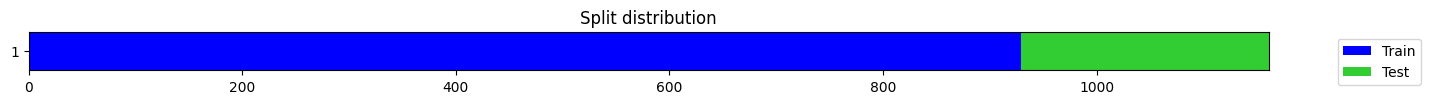

epoch,train_loss,valid_loss,mae,time
0,35.013458,38.870998,5.274079,00:12
1,34.320183,30.972017,4.597683,00:05
2,31.885227,20.082134,3.652145,00:06
3,27.782082,13.482266,3.085366,00:11
4,24.372669,11.377870,2.919722,00:07
5,22.085608,11.162695,2.905054,00:04
6,20.692320,11.257928,2.917050,00:05
7,19.874105,11.301787,2.922306,00:05
8,19.314451,11.290540,2.921286,00:04
9,18.867668,11.273233,2.919319,00:05


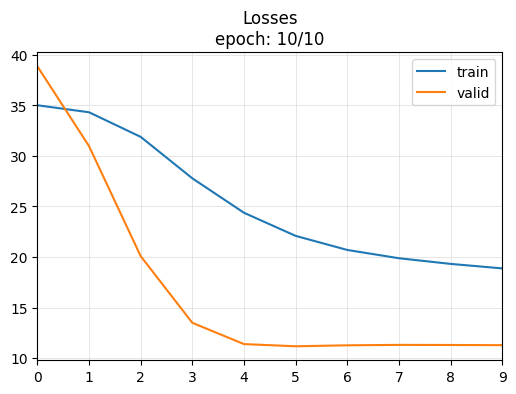

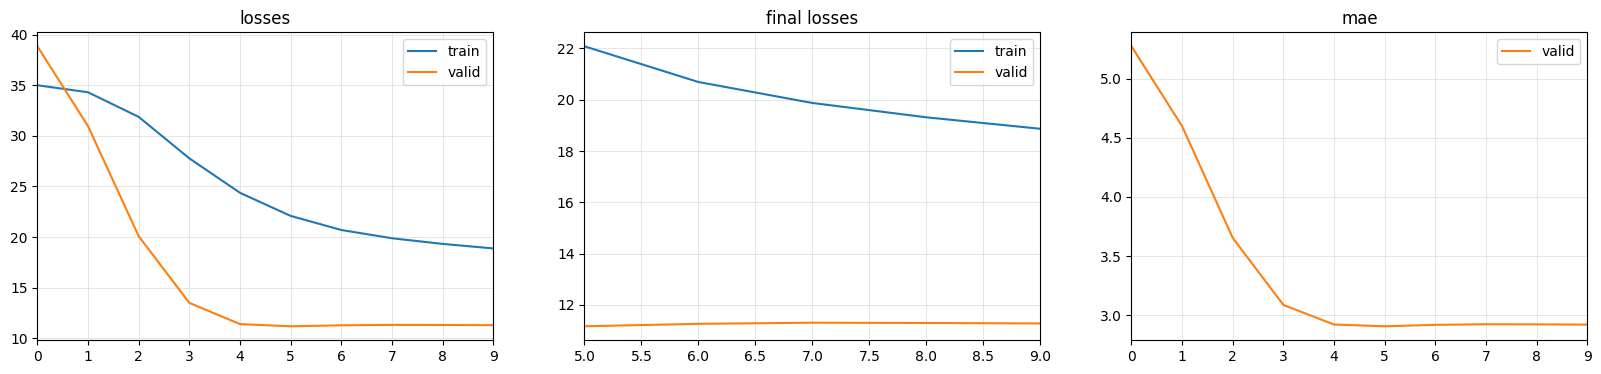

In [ ]:
X, y = SlidingWindow(60, horizon=1)(ts)
print(X)
splits = TimeSplitter()(y)
tfms = [None, TSForecasting()]
batch_tfms = TSStandardize()
fcst = TSForecaster(X, y, splits=splits, path='models', tfms=tfms, batch_tfms=batch_tfms, bs=512, arch="TSTPlus",metrics=mae, cbs=ShowGraph())
fcst.fit_one_cycle(10, 1e-3)
fcst.export("fcst.pkl")

In [ ]:
from tsai.inference import load_learner
fcst = load_learner("models/fcst.pkl", cpu=False)
raw_preds, target, preds = fcst.get_X_preds(X[splits[1]], y[splits[1]])
raw_preds.shape
# print("Raw Predictions:", raw_preds)
# print("Target Values:", target)

In [ ]:
#  label_encoder was used to encode activity names
original_activity_names = label_encoder.inverse_transform(target.numpy().astype(int))
predicted_activity_names = label_encoder.inverse_transform(raw_preds.numpy().astype(int).squeeze())

# now here we are Printing original and predicted activity names for comparison
for original, predicted in zip(original_activity_names, predicted_activity_names):
    print(f"Original: {original}, Predicted: {predicted}")


In [ ]:
import numpy as np

# Calculate Mean Absolute Error (MAE)
mae = np.abs(raw_preds - target).mean()

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(((raw_preds - target) ** 2).mean())

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 2.98
Root Mean Squared Error (RMSE): 3.48
